# 1D Kalman Filter: Smoothing Car-following trajectories collected by autonomous vehicles

We will use KF to smooth raw trajectory data collected by Lyft level-5 autonomous vehicles.

### Requirements:
* Only the following python packages are required:
``` bash
python >=3.8
zarr
numpy
matplotlib
```

* Downloading the dataset via [download page (click)](https://surfdrive.surf.nl/files/index.php/s/eZuZhZWQWs9ZUGM), unzip it, and put it in the root directory

* we will complete the code and explore how to tune the covariance matrices.

* Read the n-th car-following pairs from the dataset, using the following code:

In [1]:
import numpy as np 
import zarr
import matplotlib.pyplot as plt
%matplotlib inline

data = zarr.open('/Users/srahmani/Library/CloudStorage/OneDrive-DelftUniversityofTechnology/Edu/Courses/AI and Traffic -- TRAIL/assignment/valAV.zarr', mode='r')

def read_cf_pair(dt, n):
    start, end = dt.index_range[n]
    timestamps = dt.timestamp[start:end]
    t = (timestamps-timestamps[0]) # read time and convert it to second

    lead_centroid = dt.lead_centroid[start: end]
    follow_centroid = dt.follow_centroid[start: end]
    follow_velocity = dt.follow_velocity[start: end]
    lead_velocity = dt.lead_velocity[start: end]
    follow_acceleration = dt.follow_acceleration[start: end]
    lead_acceleration = dt.lead_acceleration[start: end]

    return lead_centroid, follow_centroid, follow_velocity, follow_acceleration, lead_acceleration, lead_velocity, t


In [2]:
# read the 96-th car-followng pairs. The leading vehicle is an AV, only positions are provided. 
# The following vehicle is an HV, both positon and speed are provided
x_lead, x_follow, v_follow, a_follow, a_lead, v_lead, t = read_cf_pair(data, 120)
follower_size = 5

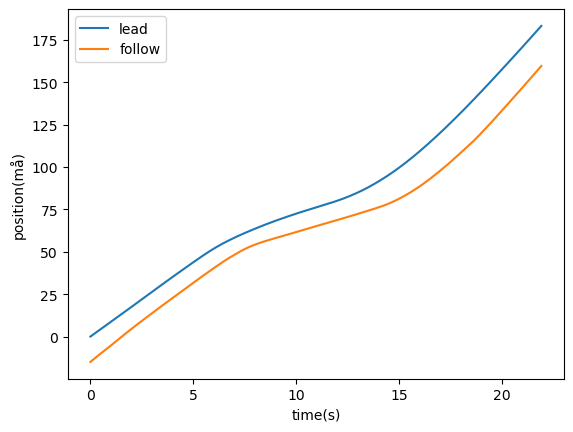

In [3]:
# visualize th car-following positions:
plt.plot(t, x_lead, label='lead')
plt.plot(t, x_follow, label='follow')
plt.xlabel('time(s)')
plt.ylabel('position(må)')
plt.legend()
plt.show()

In [10]:
import numpy as np
from scipy.optimize import minimize

def desired_gap(v, delta_v, s0, T, a, b):
    return s0 + v * T + (v * delta_v) / (2 * np.sqrt(a * b))

def idm_accel(v, s, delta_v, v0, s0, T, a, b, delta=4):
    s_star = desired_gap(v, delta_v, s0, T, a, b)
    return a * (1 - (v/v0)**delta - (s_star/s)**2)

def objective(params, v_follower, s, delta_v, a_follower):
    v0, s0, T, a, b = params
    predicted_accel = idm_accel(v_follower, s, delta_v, v0, s0, T, a, b)
    return np.sum((predicted_accel - a_follower)**2)

def calibrate_idm(lead_velocity, follow_velocity, lead_centroid, follow_centroid, follow_acceleration, follow_size):
    s_t = lead_centroid - follow_centroid - follow_size
    delta_v = lead_velocity - follow_velocity
    
    initial_guess = [30, 2, 1.5, 1, 1.5]  # [v0, s0, T, a, b]
    bounds = [(10, 50), (0, 10), (0, 5), (0, 3), (0, 3)]
    
    result = minimize(objective, initial_guess, args=(follow_velocity, s_t, delta_v, follow_acceleration),
                      bounds=bounds, method='SLSQP')
    
    return result.x, result.fun

params, function_out = calibrate_idm(v_lead, v_follow, x_lead, x_follow, a_follow, follower_size)
print(params)  # [v0, s0, T, a, b]
print(function_out)

[5.00000000e+01 8.58366570e-13 1.03241569e-11 3.18303648e-01
 1.88156176e+00]
213.3096919658663


/var/folders/bh/rfgsq1xd0j53cg5bk6h90f4jf31sz6/T/ipykernel_1243/3219568001.py:5: RuntimeWarning: divide by zero encountered in divide
  return s0 + v * T + (v * delta_v) / (2 * np.sqrt(a * b))


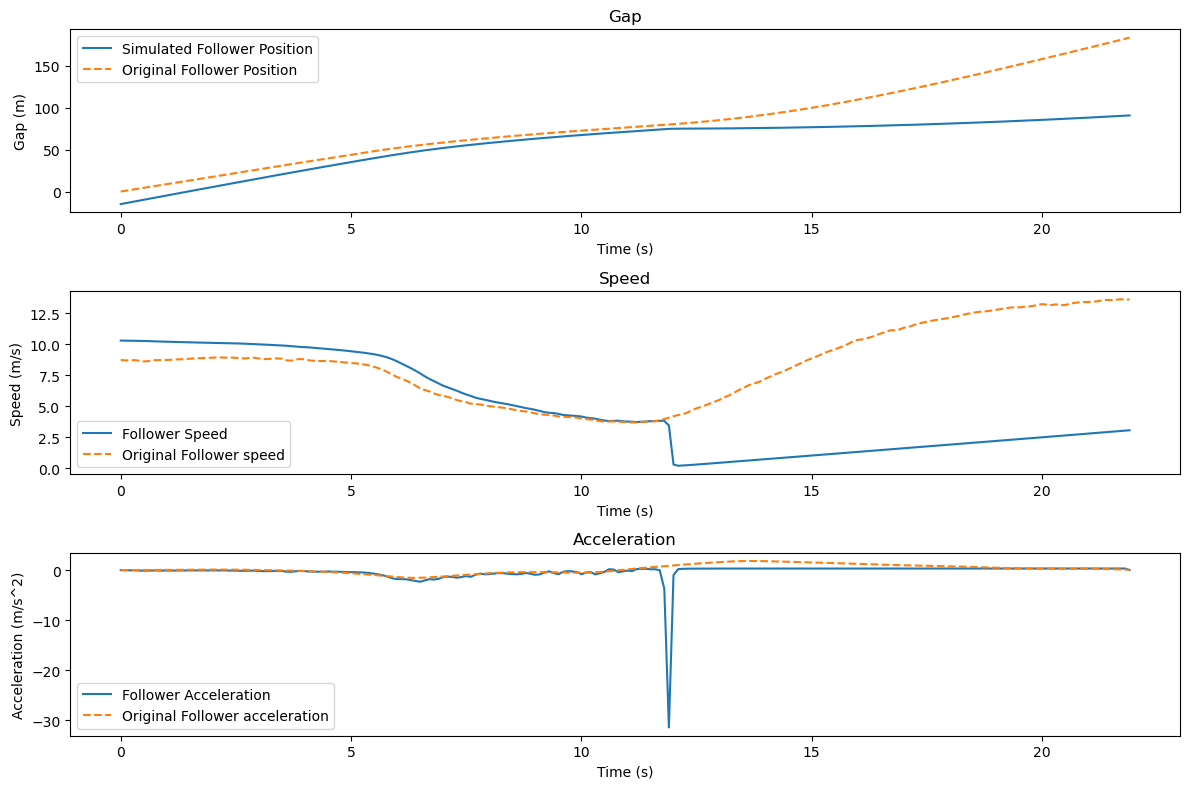

In [17]:
import numpy as np
import matplotlib.pyplot as plt

def idm_acc(v, s_t, delta_v, v0, s0, T, a, b, delta=4):
    s_star = s0 + v * T + (v * delta_v) / (2 * np.sqrt(a * b))
    return a * (1 - (v/v0)**delta - (s_star/s_t)**2)

def simulate_trajectory(params, x_leader, v_leader, pos_initial, v_initial, dt, total_time):
    v0, s0, T, a, b = params
    
    time_steps = int(total_time / dt)
    pos_follower = np.zeros(time_steps)
    v_follower = np.zeros(time_steps)
    a_follower = np.zeros(time_steps)

    pos_follower[0] = pos_initial
    v_follower[0] = v_initial

    # for i in range(1, time_steps):
    #     delta_v = v_leader[i-1] - v_follower[i-1]
    #     s_t = x_leader[i-1] - pos_follower[i-1] - follower_size
    #     a_follower[i-1] = idm_acc(v_follower[i-1], s_t, delta_v, v0, s0, T, a, b, 4)
        
    #     v_follower[i] = v_follower[i-1] + a_follower[i-1] * dt
    #     pos_follower[i] = pos_follower[i-1] + v_follower[i-1] * dt + 0.5 * a_follower[i-1] * dt**2
    
    for i in range(time_steps-1):
        delta_v = v_leader[i] - v_follower[i]
        s_t = x_leader[i] - pos_follower[i] - follower_size
        a_follower[i] = idm_acc(v_follower[i], s_t, delta_v, v0, s0, T, a, b, 4)
        
        v_follower[i+1] = v_follower[i] + a_follower[i] * dt
        pos_follower[i+1] = pos_follower[i] + v_follower[i] * dt + 0.5 * a_follower[i] * dt**2    

    return pos_follower, v_follower, a_follower

# Calibrated parameters

# Initial conditions (just for example, you can change them)
pos_initial = x_follow[0]  # Initial Position of the follower
s_initial = x_lead[0] - x_follow[0] - follower_size
v_initial = v_follow[0]  # Initial follower speed

# Simulation time step and total time
dt = 0.1  # time step, e.g., 0.1 seconds
total_time = len(x_lead) / 10 # e.g., 100 seconds

# Assuming a constant leader velocity for simplicity
# v_leader = np.ones(int(total_time / dt)) * v_lead  # Leader travels at 15 m/s

pos_simulated, v_simulated, a_simulated = simulate_trajectory(params, x_lead, v_lead, pos_initial, v_initial, dt, total_time)
pos_original, v_original, a_original = x_lead, v_lead, a_lead
# Plotting
plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
plt.plot(np.arange(0, total_time, dt), pos_simulated, label='Simulated Follower Position')
plt.plot(np.arange(0, len(pos_original) * dt, dt), pos_original, label='Original Follower Position', linestyle='--')
plt.title('Gap')
plt.xlabel('Time (s)')
plt.ylabel('Gap (m)')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(np.arange(0, total_time, dt), v_simulated, label='Follower Speed')
plt.plot(np.arange(0, len(pos_original) * dt, dt), v_original, label='Original Follower speed', linestyle='--')
plt.title('Speed')
plt.xlabel('Time (s)')
plt.ylabel('Speed (m/s)')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(np.arange(0, total_time, dt), a_simulated, label='Follower Acceleration')
plt.plot(np.arange(0, len(pos_original) * dt, dt), a_original, label='Original Follower acceleration', linestyle='--')
plt.title('Acceleration')
plt.xlabel('Time (s)')
plt.ylabel('Acceleration (m/s^2)')
plt.legend()

plt.tight_layout()
plt.show()


In [16]:
pos_simulated

array([-14.9423011 , -13.91271281, -12.88355405, -11.8550119 ,
       -10.82712137,  -9.80003911,  -8.7741448 ,  -7.74960787,
        -6.72621753,  -5.70383694,  -4.6825452 ,  -3.66238081,
        -2.64331952,  -1.6253004 ,  -0.60829523,   0.40771804,
         1.42283359,   2.43712573,   3.45063075,   4.46335584,
         5.47530721,   6.48651679,   7.49701541,   8.50676774,
         9.51563568,  10.52353647,  11.53035688,  12.53578825,
        13.53958369,  14.54186356,  15.54282413,  16.54216682,
        17.53938579,  18.53432675,  19.5271823 ,  20.51818573,
        21.50734406,  22.49385256,  23.47683834,  24.45680073,
        25.43462491,  26.41037586,  27.38343872,  28.35325398,
        29.31966188,  30.28274256,  31.24268771,  32.19950002,
        33.15298105,  34.10284493,  35.0487469 ,  35.99046558,
        36.92792995,  37.86092746,  38.78899756,  39.71143159,
        40.62715892,  41.53478736,  42.43259668,  43.3181674 ,
        44.18856809,  45.04150786,  45.87621654,  46.69

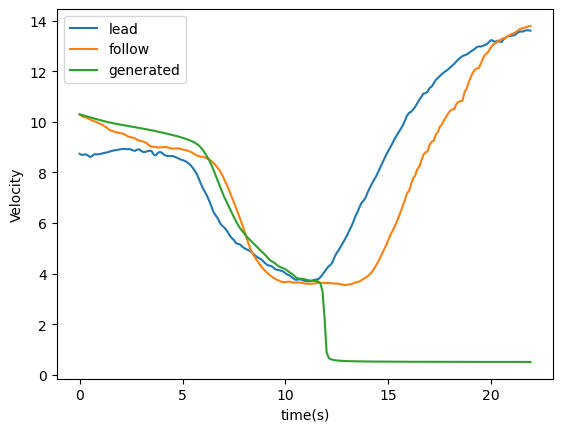

In [6]:
# visualize th car-following positions:
plt.plot(t, v_lead, label='lead')
plt.plot(t, v_follow, label='follow')
plt.plot(t, v_simulated, label='generated')
plt.xlabel('time(s)')
plt.ylabel('Velocity')
plt.legend()
plt.show()

/var/folders/bh/rfgsq1xd0j53cg5bk6h90f4jf31sz6/T/ipykernel_1243/1265351233.py:5: RuntimeWarning: overflow encountered in scalar multiply
  s_star = s0 + v * T + (v * delta_v) / (2 * np.sqrt(a * b))
/var/folders/bh/rfgsq1xd0j53cg5bk6h90f4jf31sz6/T/ipykernel_1243/1265351233.py:6: RuntimeWarning: overflow encountered in scalar power
  return a * (1 - (v/v0)**delta - (s_star/s)**2)
/var/folders/bh/rfgsq1xd0j53cg5bk6h90f4jf31sz6/T/ipykernel_1243/1265351233.py:6: RuntimeWarning: invalid value encountered in scalar divide
  return a * (1 - (v/v0)**delta - (s_star/s)**2)


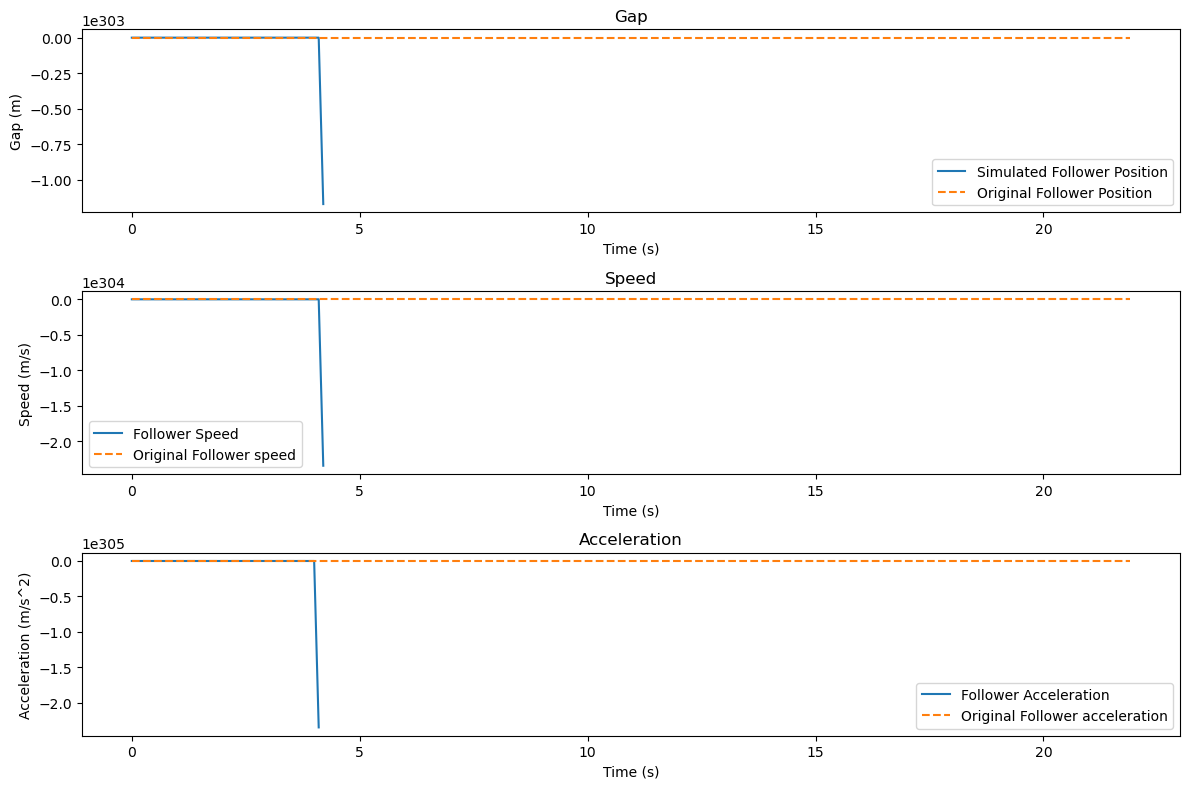

In [18]:
import numpy as np
import matplotlib.pyplot as plt

def idm_acc(v, s, delta_v, v0, s0, T, a, b, delta=4):
    s_star = s0 + v * T + (v * delta_v) / (2 * np.sqrt(a * b))
    return a * (1 - (v/v0)**delta - (s_star/s)**2)

def simulate_trajectory(params, x_leader, v_leader, pos_initial, v_initial, dt, total_time):
    v0, s0, T, a, b = params
    
    time_steps = int(total_time / dt)
    pos_follower = np.zeros(time_steps)
    v_follower = np.zeros(time_steps)
    a_follower = np.zeros(time_steps)

    pos_follower[0] = pos_initial
    v_follower[0] = v_initial

    for i in range(1, time_steps):
        delta_v = v_leader[i-1] - v_follower[i-1]
        s_t = x_leader[i-1] - pos_follower[i-1] - follower_size
        a_follower[i-1] = idm_acc(v_follower[i-1], s_t, delta_v, v0, s0, T, a, b, 4)
        
        v_follower[i] = v_follower[i-1] + a_follower[i-1] * dt
        pos_follower[i] = pos_follower[i-1] + v_follower[i-1] * dt + 0.5 * a_follower[i-1] * dt**2

    return pos_follower, v_follower, a_follower

# Calibrated parameters

# Initial conditions (just for example, you can change them)
pos_initial = x_follow[0]  # Initial Position of the follower
s_initial = x_lead[0] - x_follow[0] - follower_size
v_initial = v_follow[0]  # Initial follower speed

# Simulation time step and total time
dt = 0.1  # time step, e.g., 0.1 seconds
total_time = len(x_lead) / 10 # e.g., 100 seconds

# Assuming a constant leader velocity for simplicity
# v_leader = np.ones(int(total_time / dt)) * v_lead  # Leader travels at 15 m/s

params_new = [30, 1, 1, 1, 1.5]
pos_simulated, v_simulated, a_simulated = simulate_trajectory(params_new, x_lead, v_lead, pos_initial, v_initial, dt, total_time)
pos_original, v_original, a_original = x_lead, v_lead, a_lead
# Plotting
plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
plt.plot(np.arange(0, total_time, dt), pos_simulated, label='Simulated Follower Position')
plt.plot(np.arange(0, len(pos_original) * dt, dt), pos_original, label='Original Follower Position', linestyle='--')
plt.title('Gap')
plt.xlabel('Time (s)')
plt.ylabel('Gap (m)')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(np.arange(0, total_time, dt), v_simulated, label='Follower Speed')
plt.plot(np.arange(0, len(pos_original) * dt, dt), v_original, label='Original Follower speed', linestyle='--')
plt.title('Speed')
plt.xlabel('Time (s)')
plt.ylabel('Speed (m/s)')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(np.arange(0, total_time, dt), a_simulated, label='Follower Acceleration')
plt.plot(np.arange(0, len(pos_original) * dt, dt), a_original, label='Original Follower acceleration', linestyle='--')
plt.title('Acceleration')
plt.xlabel('Time (s)')
plt.ylabel('Acceleration (m/s^2)')
plt.legend()

plt.tight_layout()
plt.show()


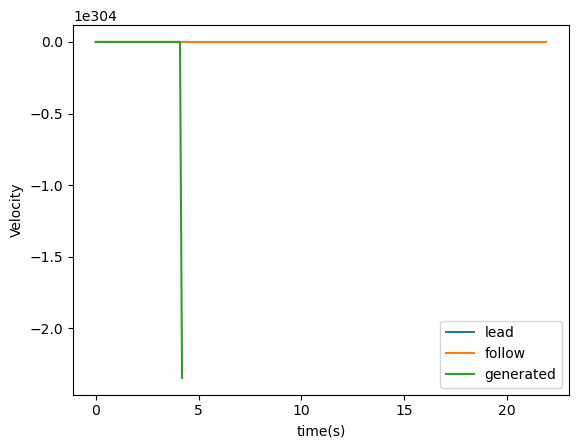

In [11]:
# visualize th car-following positions:
plt.plot(t, v_lead, label='lead')
plt.plot(t, v_follow, label='follow')
plt.plot(t, v_simulated, label='generated')
plt.xlabel('time(s)')
plt.ylabel('Velocity')
plt.legend()
plt.show()

* The aim is to get the smoothed position, speed, and acceleration series for both AV and HV.
* Now let's apply the basic 1D Kalman Filter function

In [ ]:
def KalmanFilter_AV(xin, t, P, Q, R):
    dt = np.diff(t) # get time intervals
    T = len(xin) # nb of timesteps
    I = np.eye(3)

    # Define the Observation matrix H
    H = np.matrix(   , dtype=float)

    # the initial observation
    x = np.matrix([[xin[0]]]).T

    # create a numpy array to store the smoothed result
    estimate = np.zeros((T,3,1))

    estimate[0] = x[:,0]

    # start the iteration
    for t in range(1,T):
        # We use the constant acceleration model here (a is constant within the time interval)
        # Define the state-transition matric here
        F = np.matrix(  , dtype=float)

        # Run one step simulation
        x = F*x

        # Upate the posterior  estimate covariance matrix
        P = 

        # Update the observation
        hx = np.matrix([[float(x[0])]])

        # Calculate innovation matrix
        S = 

        # Calculate optimal Kalman gain
        K = 

        # Update state observation
        Z = np.matrix([[float(xin[t])]])

        # Measurement post-fit residual
        yr = Z - hx

        # Update state estimate
        x = 
        P = 

        #Put the smoothed result in the array
        estimate[t] = x[:,0]
    output = estimate.squeeze()
    return output



In [ ]:
# Now we complete the Kalman Filter for HV
def KalmanFilter_HV(xin, vin, t, P, Q, R):
    dt = np.gradient(t)
    T = len(xin)
    I = np.eye(3)

    H = np.matrix([[1., 0., 0.],
                   [0., 1., 0.]], dtype=float)

    ae = np.gradient(vin)/dt
    a0 = min(max(np.mean(ae[:5]), -8), 5)
    x = np.matrix([[xin[0], vin[0], a0]]).T


    estimate = np.zeros((T,3,1))

    estimate[0] = x[:,0]
    for t in range(1,T):
        
        F = np.matrix([[1., dt[t], dt[t]**2/2],
                       [0., 1., dt[t]],
                       [0., 0., 1.]])

        x = F*x
        P = F*P*F.T + Q

        hx = np.matrix([[float(x[0])],
                        [float(x[1])]])
        S = H*P*H.T + R

        K = (P*H.T) * np.linalg.inv(S.astype('float'))
        Z = np.matrix([[float(xin[t])],
                       [float(vin[t])]])
        yr = Z - hx
        x = x + (K*yr)
        P = (I - (K*H))*P

        estimate[t] = x[:,0]
    output = estimate.squeeze()
    return output

In [ ]:
# Now we define our own P, Q, R, tune their values, and explore how they influence the smoothing results.
P1 =
Q1 =
R1 =

S_lead = KalmanFilter_AV(x_lead, t, P1 ,Q1, R1)

smoothed_lead_x, smoothed_lead_v, smoothed_lead_a = S_lead[:,0], S_lead[:,1], S_lead[:,2]

In [ ]:
P2 = 10*np.eye(3,3)
Q2 = np.diag([0.2, 0.5, 2.5])**2
R2 = np.diag([0.5, 0.01])**2

S_follow = KalmanFilter_HV(x_follow, v_follow, t, P2 ,Q2, R2)

smoothed_follow_x, smoothed_follow_v, smoothed_follow_a = S_follow[:,0], S_follow[:,1], S_follow[:,2]

In [ ]:
fig, ax = plt.subplots(3,1,figsize=(8,8))

ax[0].plot(t, x_follow, c='black', label = 'raw')
ax[0].plot(t, smoothed_follow_x, c='red', label = 'smoothed')
ax[0].legend()
ax[0].set_ylabel('position(m)')

ax[1].plot(t, v_follow, c='black', label = 'raw')
ax[1].plot(t, smoothed_follow_v, c='red', label = 'smoothed')
ax[1].legend()
ax[1].set_ylabel('speed(m/s)')

ax[2].plot(t, np.gradient(v_follow,t), c='black', label = 'raw')
ax[2].plot(t, smoothed_follow_a, c='red', label = 'smoothed')
ax[2].legend()
ax[2].set_ylabel('acceleration (m/s^2)')

ax[2].set_xlabel('time(s)')
plt.tight_layout()
plt.show()
